# Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import dask as dd
import seaborn as sns

In [2]:
# Load the data 
admissions = pd.read_csv('../data/core/admissions.csv')
patients = pd.read_csv('../data/core/patients.csv')
diagnose = pd.read_csv('../data/hosp/d_icd_diagnoses.csv')
subj_diagnose = pd.read_csv('../data/hosp/diagnoses_icd.csv')
icu_stays = pd.read_csv('../data/icu/icustays.csv')

# Select the Cohort 
Here we select the patients dignosed with ICH from the whole hospital addmission. The corresponding ICD codes are 'I61*' (ICD-10) and '431*' (ICD-9). 


Then we filter the patients who were addmitteed to the intensive care unit. 

In [3]:
icu_ids = icu_stays['subject_id'].unique()

In [4]:
def get_icu_cohort(icd10, icd9):
    df1=patients.set_index('subject_id')
    df_icd10=subj_diagnose[subj_diagnose['icd_code'].str.contains(str(icd10))]
    df_icd9 = subj_diagnose[subj_diagnose['icd_code'].str.contains(str(icd9))]
    df_icdall=pd.concat([df_icd9,df_icd10]).drop_duplicates('subject_id', keep='first')
    df_icu = df_icdall[df_icdall['subject_id'].isin(icu_ids)].set_index('subject_id')
    data = df_icu.join(df1,how='left')
    data['dod']=data['dod'].replace(np.nan, 0, regex=True)
    data['dod']=data['dod'].replace('-', 1, regex=True)

    return data

def mortality_rate(df):
    return np.count_nonzero(df['dod']==1)/len(df['dod'])

In [5]:
cohort = get_icu_cohort('I61',r'^431')
print('cohort size', cohort.shape[0])
print('mortality rate', mortality_rate(cohort))
cohort

cohort size 2485
mortality rate 0.2784708249496982


,hadm_id,seq_num,icd_code,icd_version,gender,anchor_age,anchor_year,anchor_year_group,dod
subject_id,,,,,,,,,
12116269,24214849,2,431,9,M,66,2166,2008 - 2010,0
12155595,26672436,2,431,9,F,52,2168,2008 - 2010,0
19620109,26497452,2,431,9,F,66,2128,2008 - 2010,0
19330004,20802265,1,431,9,M,52,2187,2008 - 2010,0
18414729,22609366,2,431,9,F,60,2152,2008 - 2010,0
...,...,...,...,...,...,...,...,...,...
14050724,20952526,1,I615,10,F,57,2112,2011 - 2013,0
12557389,21294125,1,I613,10,F,79,2151,2017 - 2019,0
18065731,25556934,1,I618,10,M,46,2137,2011 - 2013,0


# Select Features

In [6]:
def get_data(cohort_index, data_table, index_colname):
    return data_table[data_table[index_colname].isin(cohort_index)]

In [7]:
def fill_na_mean(df, rd=2, inplace=True):
    for col in list(df.columns[df.isnull().sum() > 0]):
        mean_val = df[col].mean()
        if inplace:
            try:
                df[col].fillna(round(mean_val,rd),inplace=inplace)
            except TypeError:
                continue
        else:
            try:
                df = df[col].fillna(round(mean_val,rd))
            except TypeError:
                continue
    if not inplace:
        return df

In [8]:
cohort_ind = cohort.index

## Load Vital Signs




In [9]:
vital_raw = pd.read_csv('../data/ed/vitalsign.csv')
vital_raw.head()

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,16113983,37539106,2116-06-10 00:32:00,98.2,82.0,15.0,NaN,106.0,72.0,NaN,NaN
1,15128994,30058281,2167-08-29 02:25:00,98.3,79.0,20.0,97.0,126.0,73.0,NaN,0
2,15128994,30058281,2167-08-29 04:51:00,97.6,79.0,20.0,98.0,126.0,73.0,NaN,0
3,15128994,30058281,2167-08-29 05:35:00,98.3,76.0,18.0,NaN,123.0,68.0,NaN,0/10
4,18019452,37300626,2148-12-19 12:34:00,98.1,100.0,16.0,98.0,129.0,86.0,NaN,0


In [10]:
# Drop rhythm, pain which have a lot of missing data
vital_id = get_data(cohort_ind, vital_raw, 'subject_id' ).iloc[:,:-2]
vital_id.head()

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp
105,10046166,38848658,2132-12-06 11:53:00,97.0,75.0,12.0,NaN,154.0,73.0
261,10900387,30300312,2146-09-08 01:25:00,98.8,79.0,16.0,93.0,162.0,87.0
525,16652205,35474533,2169-04-09 18:55:00,NaN,73.0,27.0,98.0,169.0,79.0
526,16652205,35474533,2169-04-09 19:50:00,NaN,70.0,45.0,100.0,187.0,69.0
527,16652205,35474533,2169-04-09 21:00:00,98.4,70.0,30.0,98.0,138.0,58.0


In [11]:
fill_na_mean(vital_id)
vital_id

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp
105,10046166,38848658,2132-12-06 11:53:00,97.00,75.0,12.0,97.55,154.0,73.0
261,10900387,30300312,2146-09-08 01:25:00,98.80,79.0,16.0,93.00,162.0,87.0
525,16652205,35474533,2169-04-09 18:55:00,97.47,73.0,27.0,98.00,169.0,79.0
526,16652205,35474533,2169-04-09 19:50:00,97.47,70.0,45.0,100.00,187.0,69.0
527,16652205,35474533,2169-04-09 21:00:00,98.40,70.0,30.0,98.00,138.0,58.0
...,...,...,...,...,...,...,...,...,...
1650418,12557389,35529368,2153-01-24 23:15:00,97.47,75.0,23.0,98.00,119.0,62.0
1650902,14745196,36076575,2204-06-17 12:14:00,97.20,89.0,16.0,98.00,129.0,86.0
1650903,14745196,36076575,2204-06-17 14:59:00,98.90,88.0,18.0,97.00,166.0,91.0
1650904,14745196,36076575,2204-06-17 18:33:00,99.50,95.0,20.0,94.00,153.0,67.0


In [12]:
vital_id =vital_id.drop_duplicates('subject_id', keep='last').set_index('subject_id')

In [13]:
vital_id.head()

,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp
subject_id,,,,,,,,
16652205,31288294,2169-04-22 23:50:00,101.40,100.0,44.0,97.55,97.0,61.0
11213607,32187974,2194-06-11 01:48:00,98.40,98.0,20.0,98.00,152.0,80.0
19620109,36855170,2132-10-16 23:43:00,98.50,67.0,15.0,100.00,101.0,67.0
16379037,37641494,2177-04-16 23:54:00,98.00,100.0,19.0,98.00,145.0,80.0
15936063,38505545,2161-05-22 16:30:00,97.47,118.0,20.0,98.00,145.0,72.0


In [14]:
final = cohort.join(vital_id)
final.shape

(2485, 17)

## Load chartted Event

In [15]:
# Select data From Google Bigquery using SQL
# This command took 20 mins to run, returns 10 milion rows of data.
# So won't run it here, we saved the output locally and then load it. 
'''
project_id = 'focus-dragon-313813'

df = pd.io.gbq.read_gbq(f"""SELECT * 
FROM `physionet-data.mimic_icu.chartevents`
WHERE subject_id in {tuple(cohort.index.values.tolist())}
ORDER BY subject_id""", project_id='focus-dragon-313813', dialect='standard')'''

'\nproject_id = \'focus-dragon-313813\'\n\ndf = pd.io.gbq.read_gbq(f"""SELECT * \nFROM `physionet-data.mimic_icu.chartevents`\nWHERE subject_id in {tuple(cohort.index.values.tolist())}\nORDER BY subject_id""", project_id=\'focus-dragon-313813\', dialect=\'standard\')'

In [16]:
# Selected Features from table event

# PH (Venous)
# Chloride (serum)
# Creatinine (serum)
# Magnesium
# Sodium (serum)
# PH (dipstick)
# Sodium Bicarbonate 8.4%
# Norepinephrine
# Magnesium Sulfate
# PH (Arterial)
# GCS - Verbal Response
# Heparin Sodium
# Chloride (whole blood)
# CreatinineApacheIIScore
# CreatinineApacheIIValue
# HematocritApacheIIScore
# WbcApacheIIScore
# WBCApacheIIValue
# Hematocrit_ApacheIV
# HR_ApacheIV
# WBC_ApacheIV
# WBCScore_ApacheIV
# Magnesium Sulfate (Bolus)
# Chloride (serum) (soft)
# Sodium (serum) (soft)
# Creatinine (whole blood)
# selected_items = [220274,220602,220615,220635,220645,220734,220995,221906,222011,223830,223900,
# 225152,226536,226751,226752,226761,226779,226780,227017,227018,227062,227063,227523,228385,228389,229761,]

In [17]:
# df[df['itemid'].isin(selected_items)].to_csv('chart_event_filtered.csv')

In [18]:
# len(df['itemid'].unique())

In [19]:
charteve_raw = pd.read_csv('../data/chart_event_filtered.csv')
charteve_raw.head()

,Unnamed: 0,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,24,10007677,27180483,34992648,2120-11-21 12:00:00,2120-11-21 13:48:00,223900,Oriented,5.0,NaN,0
1,78,10007677,27180483,34992648,2120-11-17 20:00:00,2120-11-17 20:52:00,223900,Oriented,5.0,NaN,0
2,117,10007677,27180483,34992648,2120-11-21 18:48:00,2120-11-21 19:40:00,220645,130,130.0,mEq/L,1
3,159,10007677,27180483,34992648,2120-11-19 12:00:00,2120-11-19 11:59:00,223900,Oriented,5.0,NaN,0
4,220,10007677,27180483,34992648,2120-11-19 00:40:00,2120-11-19 00:40:00,223900,Oriented,5.0,NaN,0


In [20]:
item_names = pd.read_csv('../data/icu/d_items.csv').set_index('itemid')
item_names.head()

,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
itemid,,,,,,,,
220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,NaN,Date and time,NaN,NaN
220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN
220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,NaN,NaN
220048,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,NaN,Text,NaN,NaN


In [21]:
item_dict = dict()
for item_id in charteve_raw['itemid'].unique():
    item_dict[item_id] = item_names.loc[item_id, 'abbreviation']

In [22]:
# This command takes a few minutes to run.
for i in range(charteve_raw.shape[0]):
    entry = charteve_raw.iloc[i,:]
    sub_id, itemid = entry[['subject_id', 'itemid']]
    item_names = item_dict[itemid]
    final.loc[sub_id, item_names] = entry['valuenum']
final.head() 

,hadm_id,seq_num,icd_code,icd_version,gender,anchor_age,anchor_year,anchor_year_group,dod,stay_id,...,Verbal Response,Sodium (serum),Chloride (serum),Magnesium,Creatinine (serum),PH (dipstick),PH (Venous),PH (Arterial),Creatinine (whole blood),Chloride (whole blood)
subject_id,,,,,,,,,,,,,,,,,,,,,
12116269,24214849,2,431,9,M,66,2166,2008 - 2010,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12155595,26672436,2,431,9,F,52,2168,2008 - 2010,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19620109,26497452,2,431,9,F,66,2128,2008 - 2010,0,36855170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19330004,20802265,1,431,9,M,52,2187,2008 - 2010,0,38965565.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18414729,22609366,2,431,9,F,60,2152,2008 - 2010,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
test = final.iloc[:,:-5].dropna(how='any',axis=0)
test[['dod']] = test[['dod']].astype('int')
test.describe()

,hadm_id,seq_num,icd_version,anchor_age,anchor_year,dod,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,Verbal Response,Sodium (serum),Chloride (serum),Magnesium,Creatinine (serum)
count,1.032000e+03,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1.032000e+03,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000
mean,2.494251e+07,3.006783,9.972868,67.600775,2151.091085,0.230620,3.505354e+07,97.254661,80.053295,18.133721,97.504312,130.553527,71.011008,3.290698,141.391473,104.860465,2.067539,1.095058
std,2.827824e+06,4.116037,0.162546,14.927744,23.458559,0.421434,2.922054e+06,6.473051,16.569990,3.394916,3.619704,18.580383,13.725766,1.754250,5.719082,6.414695,0.300473,1.006297
min,2.000251e+07,1.000000,9.000000,19.000000,2110.000000,0.000000,3.000467e+07,32.400000,7.000000,4.000000,2.000000,31.000000,23.000000,1.000000,116.000000,84.000000,0.400000,0.200000
25%,2.256903e+07,1.000000,10.000000,59.000000,2130.750000,0.000000,3.256712e+07,97.470000,69.000000,16.000000,96.000000,118.000000,62.000000,1.000000,138.000000,101.000000,1.900000,0.600000
50%,2.490807e+07,2.000000,10.000000,69.000000,2150.000000,0.000000,3.492956e+07,97.600000,80.000000,18.000000,98.000000,131.500000,71.000000,4.000000,141.000000,104.000000,2.000000,0.800000
75%,2.720125e+07,3.000000,10.000000,79.000000,2172.000000,0.000000,3.769880e+07,98.200000,89.000000,19.000000,100.000000,141.000000,78.000000,5.000000,144.000000,108.000000,2.200000,1.100000
max,2.999962e+07,38.000000,10.000000,91.000000,2205.000000,1.000000,3.998928e+07,105.000000,171.000000,44.000000,100.000000,206.000000,145.000000,5.000000,171.000000,140.000000,4.000000,12.800000


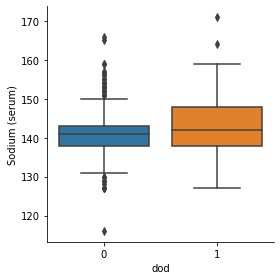

In [24]:
g = sns.catplot(x='dod',y='Sodium (serum)',data=test, kind="box",
                height=4, aspect=1);

# Description

# Modelling

In [25]:
from DS_MIMIC_knn import shuffle_split_data

In [26]:
test[test.dod==0].shape[0]/test.shape[0]

0.7693798449612403

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X = test[['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp',
       'Verbal Response', 'Sodium (serum)', 'Chloride (serum)', 'Magnesium',
       'Creatinine (serum)']]
y = test['dod']

X_train_orig, X_test_orig, y_train, y_test = shuffle_split_data(X, y,0.2)
std= StandardScaler()
X_train=std.fit_transform(X_train_orig)
X_test=std.fit_transform(X_test_orig)

[0.92180957 0.66094553 0.06772547 ... 0.90121253 0.30234674 0.51320622]


In [36]:
X_train.shape

(825, 11)

## Logistic Regression

In [37]:
# check classification scores of logistic regression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

Train/Test split results:
LogisticRegression accuracy is 0.821
LogisticRegression log_loss is 0.436
LogisticRegression auc is 0.794


color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


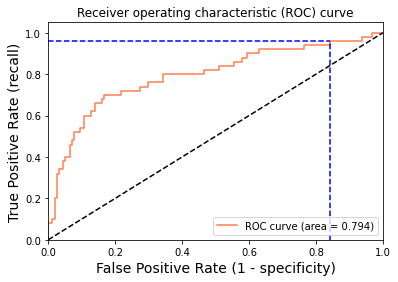

Using a threshold of 0.047 guarantees a sensitivity of 0.960 and a specificity of 0.159, i.e. a false positive rate of 84.08%.


In [38]:
idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

## Random Forest

In [41]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Fit the model
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train_orig, y_train)

# Use score method to calculate the accuracy over the whole test set
acc=rf.score(X_test_orig, y_test)
print(acc)
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X, y)


ft_imp = pd.Series(rf.feature_importances_).sort_values(ascending=False)
ft_imp.head(10)
ft_imp

0.7777777777777778


6     0.135716
10    0.121242
8     0.114779
7     0.108960
4     0.083067
5     0.082732
1     0.082326
9     0.082105
2     0.070124
0     0.066837
3     0.052113
dtype: float64

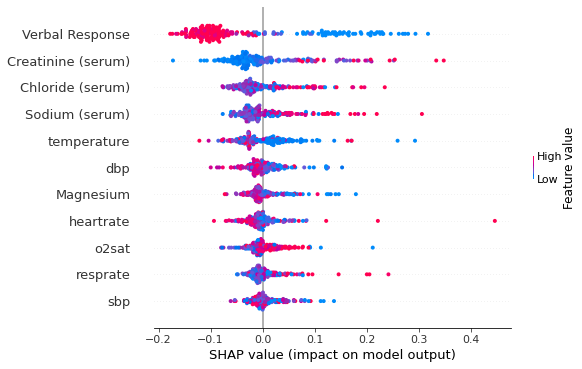

In [43]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test_orig)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test_orig)

## KNN

In [62]:
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(40)
test_scores = []
train_scores = []

for i in range(1,15):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))


In [63]:
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 100.0 % and k = [1]


In [66]:
## score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 77.77777777777779 % and k = [11, 13]


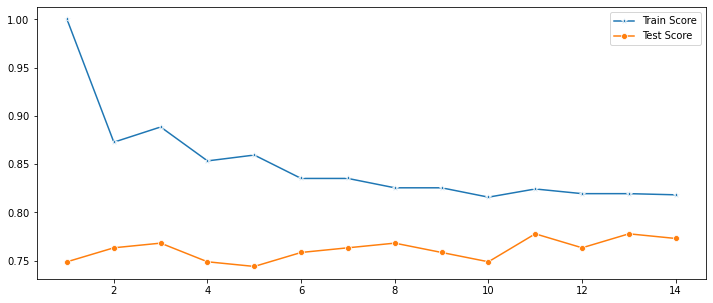

In [68]:
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,15),y=train_scores,marker='*',label='Train Score')
p = sns.lineplot(x=range(1,15),y=test_scores,marker='o',label='Test Score')

## My KNN


In [50]:
def My_knncomper_difftest(kmax):
    rightnumber = 0           
    print('enter phase 2')
    Train_acc=[]
    Test_acc=[]

    
    print(" maximum K value is "+str(kmax))           
    for k in range(1,kmax):
        test_predict_score=0
        rightnumber=0
        predictlist =MYknn(X_test_std, X_train_std, y_train, k)
        for m in range(len(X_test_std)):
            if predictlist[m] == y_test[m]:
                rightnumber = rightnumber + 1
        test_predict_score = (rightnumber / len(y_test))
        print(test_predict_score*100)
        Test_acc.append(  test_predict_score * 100)
        rightnumber=0
        Train_predict_score=0
        predictlist = MYknn(X_train_std, X_train_std, y_train, k)
        for m in range(len(X_train_std)):
            if predictlist[m] == y_train[m]:
                rightnumber = rightnumber + 1
        Train_predict_score = (rightnumber / len(X_train_std))
        Train_acc.append( Train_predict_score * 100)      
     
    plt.plot(Test_acc)
    plt.title('Test_acc')
    plt.show()
    plt.plot(Train_acc)
    plt.title('Train_acc')
    plt.show()

        
def MYknn(test_object, training_object, training_object_target, K):
    predictlist = []
    for newpoint in test_object:
        dataSetSize = training_object.shape[0]
        diffMat= np.tile(newpoint, (dataSetSize, 1)) - training_object
        sqDistances = (diffMat**2).sum(axis=1)
        distances = sqDistances ** 0.5
        sortedDistIndicies = distances.argsort()
        classCount = {}
        for i in range(K):
            voteIlabel = training_object_target[sortedDistIndicies[i]]
            classCount[voteIlabel] = classCount.get(voteIlabel, 0) + 1  #Get the value of key from the map and return 0 without key
            sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
        predictlist.append(sortedClassCount[0][0])
    return predictlist

In [51]:
## from sklearn.model_selection import train_test_split
# from DS_MIMIC_knn import *
import numpy as np
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


My_knncomper_difftest(15)

enter phase 2
 maximum K value is 15


KeyError: 242

---------------------
# Find dod ID


In [ ]:
raise TypeError

In [ ]:
# fillnan_test.set_index('subject_id',inplae=True)

In [ ]:
# dod_id=cohort[cohort['dod']==1]
# test = dod_id.join(fillnan_test,how='left')
# np.count_nonzero(test['stay_id']>1)

In [ ]:
dod_id

In [ ]:
test['stay_id']

# Load output event

In [ ]:
outevents = pd.read_csv('../data/icu/outputevents.csv')
itmes = pd.read_csv('../data/icu/d_items.csv')

In [ ]:
test_main = cohort.copy()

In [ ]:
out = outevents[outevents['subject_id'].isin(test_main.index)]

In [ ]:
for i in range(out.shape[0]):
    entry = out.iloc[i,:]
    sub_id, itemid = entry[['subject_id', 'itemid']]
    test_main.loc[sub_id, itemid] = entry['value']
test_main.head() 